In [0]:
# !nvidia-smi

In [3]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 9.1MB/s 
     |████████████████████████████████| 1.1MB 28.9MB/s 
     |████████████████████████████████| 890kB 58.9MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/157-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [8]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [9]:
# Unzip files
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/fold_1.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/fold_2.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/fold_3.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/fold_4.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/fold_5.tar.gz'


# Unzip files (balanced)
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/balanced_fold_1.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/balanced_fold_2.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/balanced_fold_3.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/balanced_fold_4.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete/balanced_fold_5.tar.gz'

fold_1/
fold_1/x_train.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux2.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/y_valid_aux.npy
fold_1/x_valid_aux2.npy
fold_1/y_train.npy
fold_1/x_valid_aux.npy
fold_1/y_train_aux.npy
fold_1/y_valid_mask.npy
fold_1/y_valid.npy
fold_2/
fold_2/x_train.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux2.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/y_valid_aux.npy
fold_2/x_valid_aux2.npy
fold_2/y_train.npy
fold_2/x_valid_aux.npy
fold_2/y_train_aux.npy
fold_2/y_valid_mask.npy
fold_2/y_valid.npy
fold_3/
fold_3/x_train.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux2.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/y_valid_aux.npy
fold_3/x_valid_aux2.npy
fold_3/y_train.npy
fold_3/x_valid_aux.npy
fold_3/y_train_aux.npy
fold_3/y_valid_mask.npy
fold_3/y_valid.npy
balanced_fold_1/
balanced_fold_1/x_train.npy
balanced_fold_1/y_train_mask.npy
balanced_fold_1/x_train_aux2.npy
balanced_fold_1/x_train_aux.npy
balanced_fold_1/x_valid.npy
balanced_fold

In [10]:
database_base_path = COLAB_BASE_PATH + 'Data/complete/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,13,14,3,train,train,validation,train,train


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 3,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 3,
  "question_size": 4,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.71e-06


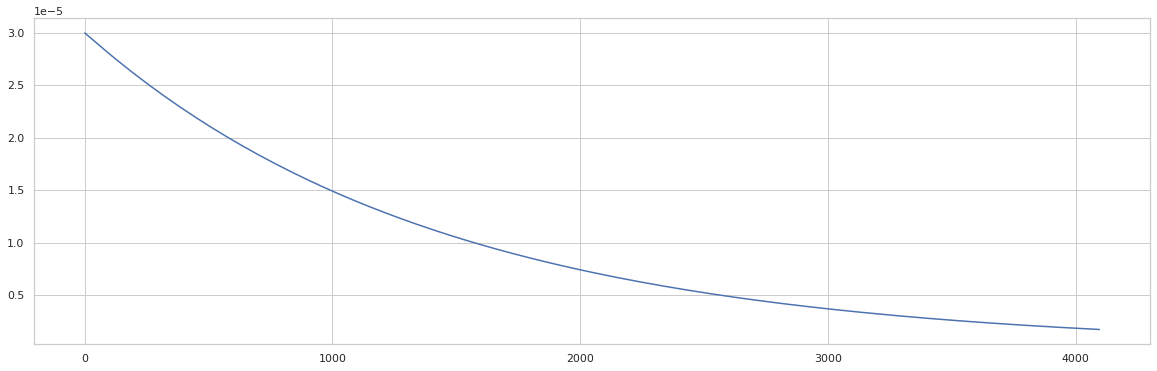

In [13]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train']) *2
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
decay = .9993

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    last_state = sequence_output[0]
    
    x_start = layers.Dropout(.1)(last_state) 
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_state) 
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [18]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    base_data_path = 'fold_%d/' % (n_fold)

    # Load data (balanced)
    x_train = np.load('balanced_' + base_data_path + 'x_train.npy')
    y_train = np.load('balanced_' + base_data_path + 'y_train.npy')

    # Load data
    x_train = np.hstack([x_train, np.load(base_data_path + 'x_train.npy')])
    y_train = np.hstack([y_train, np.load(base_data_path + 'y_train.npy')]) 
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)

    # Build TF datasets (balanced)
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn(y['y_start'], probabilities[0])
                loss_end = loss_fn(y['y_end'], probabilities[1])
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn(y['y_start'], probabilities[0])
            loss_end = loss_fn(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=1, lr_start=lr_max, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    loss_fn = losses.categorical_crossentropy
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    
    # Make predictions (last model)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)

    # Make predictions (best model)
    model.load_weights(MODEL_BASE_PATH + model_path)
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold_best['end_fold_%d' % (n_fold)] = k_fold_best['end_fold_%d' % (n_fold)].astype(int)
    k_fold_best['start_fold_%d' % (n_fold)] = k_fold_best['start_fold_%d' % (n_fold)].astype(int)
    k_fold_best['end_fold_%d' % (n_fold)].clip(0, k_fold_best['text_len'], inplace=True)
    k_fold_best['start_fold_%d' % (n_fold)].clip(0, k_fold_best['end_fold_%d' % (n_fold)], inplace=True)
    k_fold_best['prediction_fold_%d' % (n_fold)] = k_fold_best.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold_best['prediction_fold_%d' % (n_fold)].fillna(k_fold_best["text"], inplace=True)
    k_fold_best['jaccard_fold_%d' % (n_fold)] = k_fold_best.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 1270 steps, validate for 171 steps
Instructions for updating:
renamed to `run`

EPOCH 1/3
time: 484.7s loss: 1.9249 loss_start: 0.9816 loss_end: 0.9433 val_loss: 1.5951 val_loss_start: 0.8183 val_loss_end: 0.7768
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/157-roBERTa_base/model_fold_1.h5"

EPOCH 2/3
time: 474.9s loss: 1.4155 loss_start: 0.7416 loss_end: 0.6739 val_loss: 1.5900 val_loss_start: 0.8416 val_loss_end: 0.7484
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/157-roBERTa_base/model_fold_1.h5"

EPOCH 3/3
time: 476.5s loss: 1.2289 loss_start: 0.6494 loss_end: 0.5794 val_loss: 1.6650 val_loss_start: 0.8626 val_loss_end: 0.8024
Training finished

FOLD: 2
Train for 1270 steps, validate for 171 steps

EPOCH 1/3
time: 486.8s loss: 1.9211 loss_start: 0.9788 loss_end: 0.9423 val_loss: 1.6262 val_loss_start: 0.8405 val_loss_end: 0.7857
Saved model weight

# Model loss graph

Fold: 1


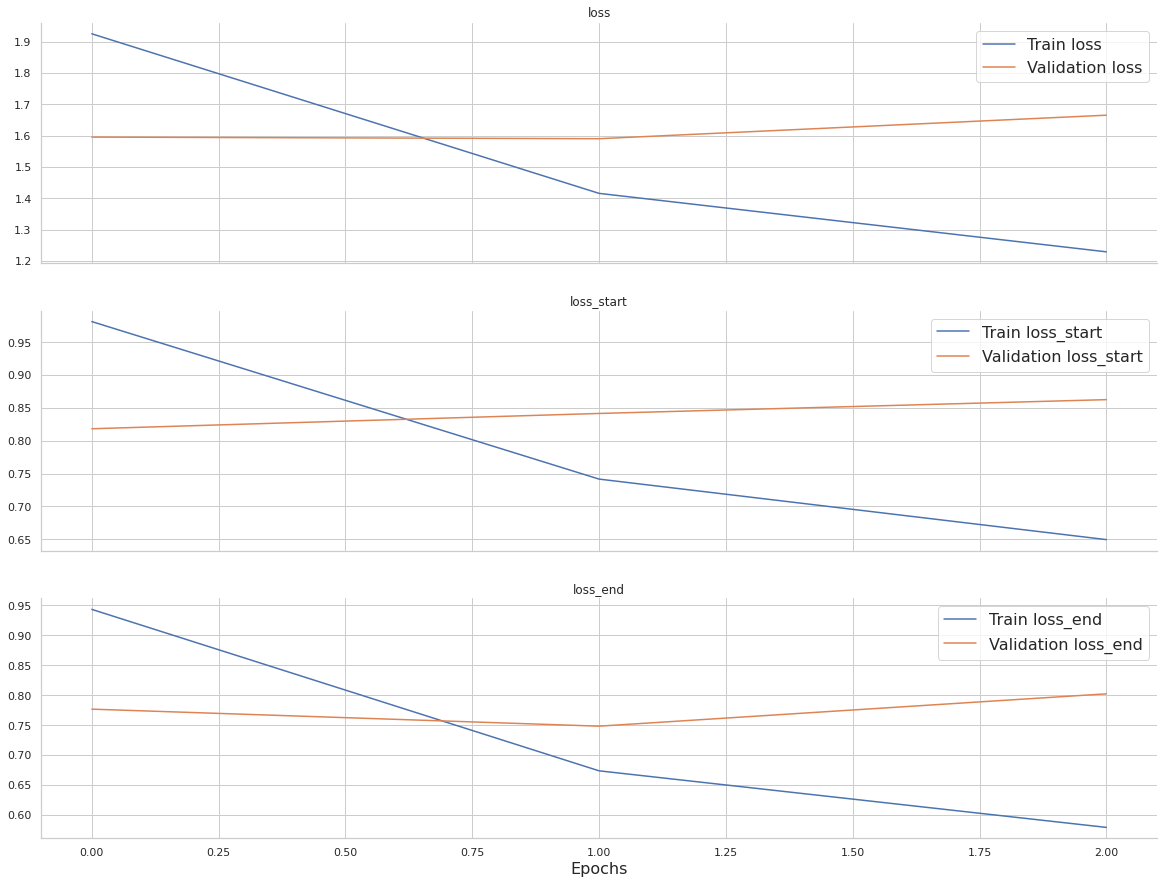

Fold: 2


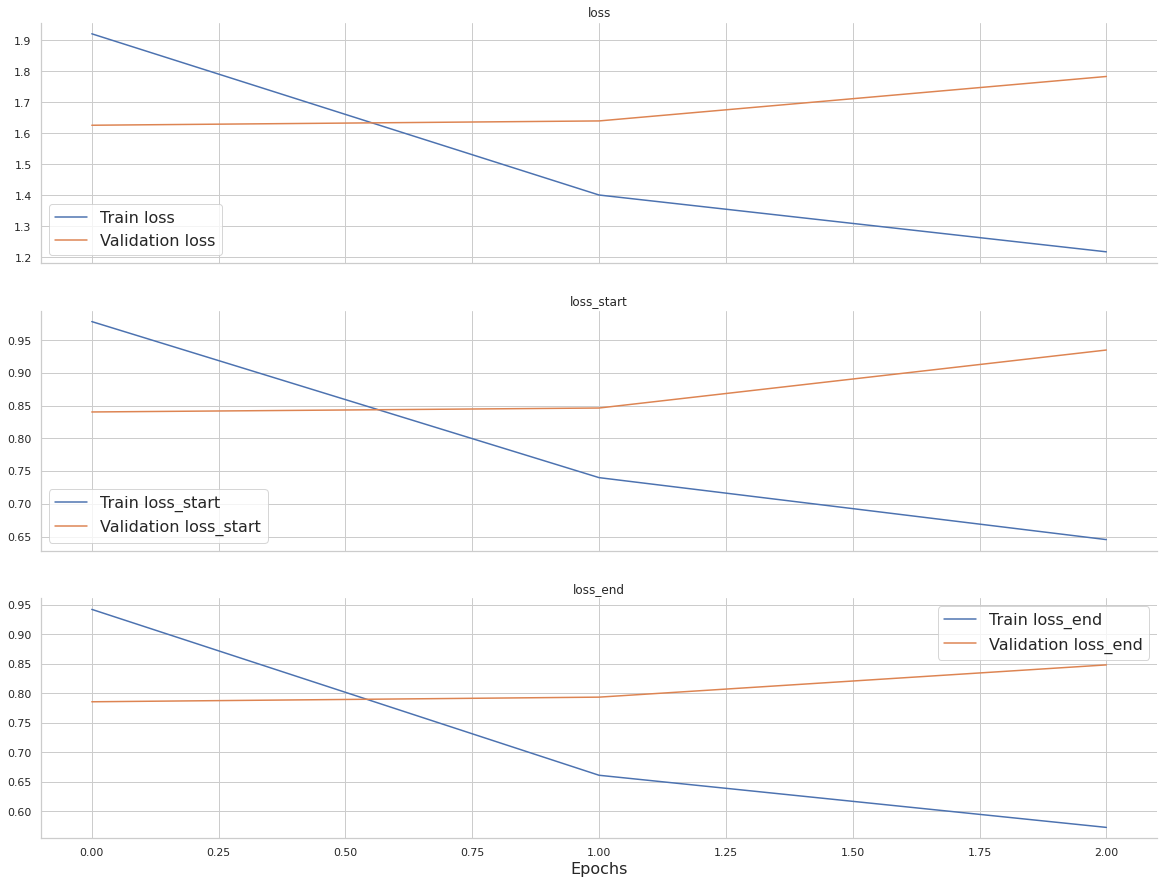

Fold: 3


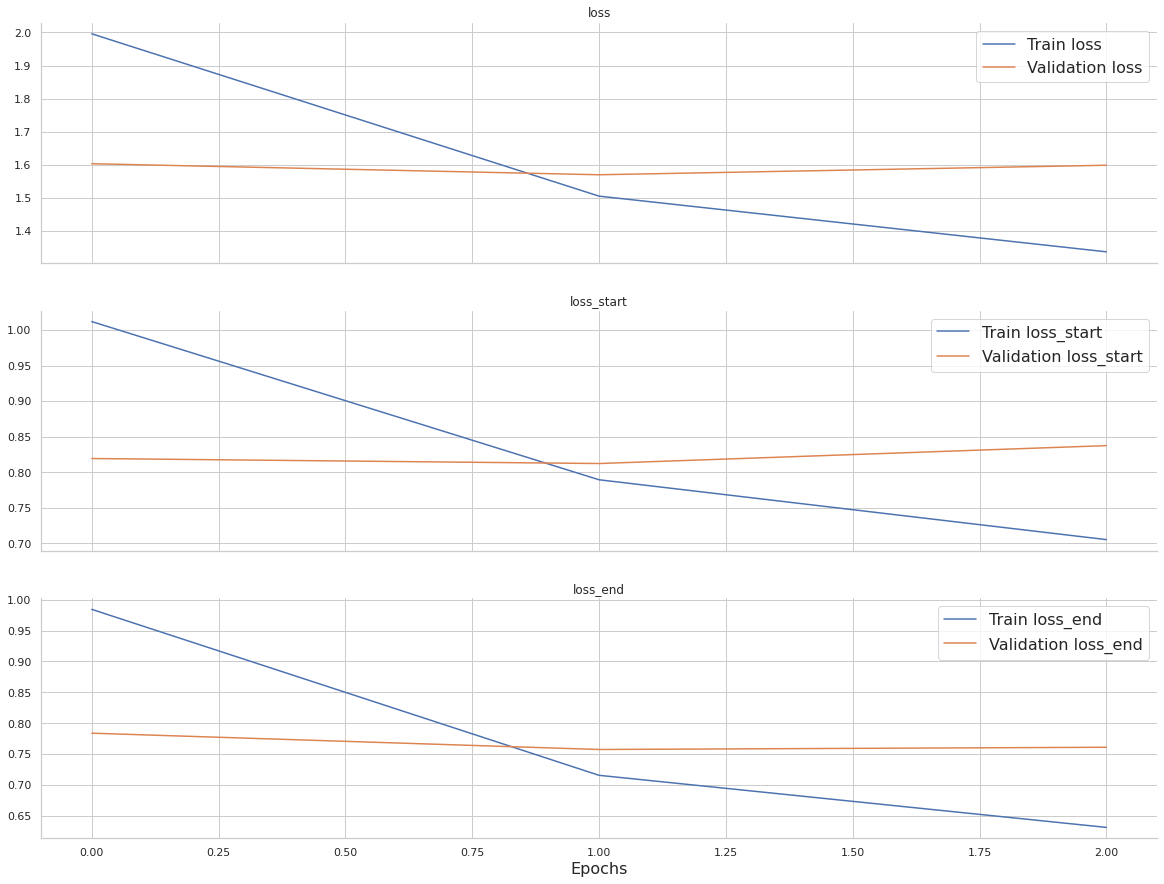

In [19]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (last model)

In [20]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.786100,0.703417,0.082683,0.793800,0.700003,0.792394,0.698780,0.772105,0.711468
Sentiment negative,0.669557,0.514886,0.154672,0.682370,0.512193,0.682066,0.510359,0.644236,0.522105
Sentiment neutral,0.976335,0.972989,0.003347,0.977097,0.973166,0.976116,0.971659,0.975793,0.974142
Sentiment positive,0.645348,0.525081,0.120267,0.657417,0.516272,0.654461,0.515970,0.624166,0.543002
0 <= text wordCnt < 3,0.871873,0.849757,0.022116,0.875583,0.813433,0.874174,0.863135,0.865861,0.872703
3 <= text wordCnt < 10,0.828030,0.763749,0.064282,0.835452,0.753993,0.831796,0.766366,0.816841,0.770887
10 <= text wordCnt < 30,0.760425,0.667259,0.093166,0.768761,0.666131,0.768059,0.659541,0.744454,0.676103
30 <= text wordCnt < 100,0.762979,0.574781,0.188198,0.761150,0.671037,0.781957,0.486770,0.745830,0.566537
0 <= selected text wordCnt < 3,0.733842,0.596343,0.137499,0.744240,0.583834,0.756921,0.605511,0.700364,0.599684


# Model evaluation (best model)

In [21]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.754340,0.705717,0.048623,0.772790,0.704492,0.736396,0.698340,0.753835,0.714319
Sentiment negative,0.612200,0.523363,0.088837,0.644060,0.519388,0.582719,0.517910,0.609820,0.532790
Sentiment neutral,0.975098,0.973727,0.001372,0.975546,0.973783,0.974680,0.973358,0.975069,0.974039
Sentiment positive,0.597262,0.523803,0.073459,0.626888,0.523325,0.567094,0.505512,0.597803,0.542571
0 <= text wordCnt < 3,0.864275,0.848308,0.015968,0.874126,0.820896,0.859459,0.863135,0.859240,0.860892
3 <= text wordCnt < 10,0.804760,0.765723,0.039037,0.821994,0.755221,0.788115,0.765071,0.804171,0.776876
10 <= text wordCnt < 30,0.723351,0.669847,0.053504,0.743219,0.672219,0.704012,0.659376,0.722823,0.677947
30 <= text wordCnt < 100,0.711459,0.579841,0.131618,0.715047,0.682965,0.703726,0.497394,0.715605,0.559163
0 <= selected text wordCnt < 3,0.693403,0.610666,0.082737,0.709547,0.588888,0.672394,0.613723,0.698267,0.629388


# Visualize predictions

In [22]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,"i`d have responded, if i were going",1.0,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,sooo sad,1.0,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,bullying,0.5,bullying,0.500000,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,leave me alone,1.0,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,"sons of ****,",1.0,"sons of ****,",1.000000,"****,",0.333333
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.0,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,fun,1.0,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,soooo high,1.0,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,both of you,1.0,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,wow... u just became cooler.,1.0,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000
